## Modelo OLS 

In [ ]:
# Se eliminan las siguientes variables, ya que son variables secundarias o poco necesarias para la prediccion 

columns_to_drop = [
    'porosity',
    'friction_angle_deg',
    'cement_quality',
    'clay_content',
    'temperature_c',
    'perforation_density_spm',
    'oil_viscosity_cp',
    'oil_density_kgm3',
    'completion_type'
]

db = db.drop(columns=columns_to_drop, errors='ignore')
print("Columnas restantes después de la eliminación:")
print(db.columns)

Columnas restantes después de la eliminación:
Index(['permeability_md', 'compressive_strength_mpa', 'cohesion_mpa',
       'grain_size_mm', 'reservoir_pressure_bar', 'water_saturation',
       'flow_rate_m3day', 'drawdown_pressure_bar',
       'sand_production_rate_kgday'],
      dtype='object')


In [ ]:
X=db[["permeability_md", "compressive_strength_mpa", "cohesion_mpa", "grain_size_mm", "reservoir_pressure_bar", "water_saturation", "flow_rate_m3day", "drawdown_pressure_bar"]]
y=db["sand_production_rate_kgday"]

X=sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     sand_production_rate_kgday   R-squared:                       0.096
Model:                                    OLS   Adj. R-squared:                  0.089
Method:                         Least Squares   F-statistic:                     13.13
Date:                        Mon, 01 Dec 2025   Prob (F-statistic):           4.00e-18
Time:                                15:16:39   Log-Likelihood:                -4268.2
No. Observations:                        1000   AIC:                             8554.
Df Residuals:                             991   BIC:                             8598.
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [ ]:
# Escalado de datos
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
X_scaled_const=sm.add_constant(X_scaled)
model_scaled = sm.OLS(y, X_scaled_const).fit()
print(model_scaled.summary())

                                OLS Regression Results                                
Dep. Variable:     sand_production_rate_kgday   R-squared:                       0.096
Model:                                    OLS   Adj. R-squared:                  0.089
Method:                         Least Squares   F-statistic:                     13.13
Date:                        Mon, 01 Dec 2025   Prob (F-statistic):           4.00e-18
Time:                                15:16:39   Log-Likelihood:                -4268.2
No. Observations:                        1000   AIC:                             8554.
Df Residuals:                             991   BIC:                             8598.
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## Modelo Random Forest Regresor

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf=RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 281.20262610621916
R^2 Score: 0.13886236400768748


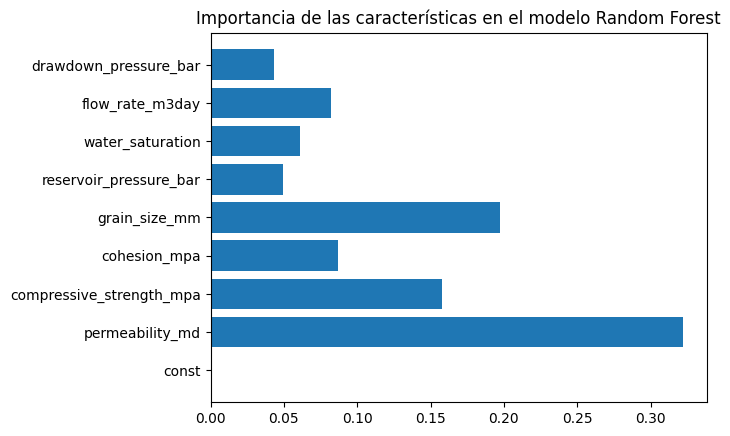

In [ ]:
importances = rf.feature_importances_
plt.barh(X.columns, importances)
plt.title('Importancia de las características en el modelo Random Forest')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_base = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='r2'
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R² en CV:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
print("R² test:", r2_score(y_test, y_pred))
print("MSE test:", mean_squared_error(y_test, y_pred))


Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Mejor R² en CV: -0.3840321902736557
R² test: 0.11105441999883725
MSE test: 290.2832498707264


## Modelo XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R²: -0.8114234986633753
MSE: 591.5164121559817


In [ ]:
y.describe()

count    1000.000000
mean        2.577642
std        18.175901
min         0.000000
25%         0.003760
50%         0.029923
75%         0.212279
max       341.014050
Name: sand_production_rate_kgday, dtype: float64

<Axes: >

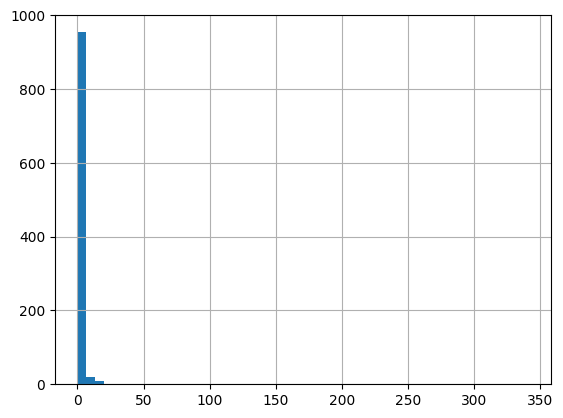

In [ ]:
y.hist(bins=50)

In [ ]:
# Eliminar los 5 valores más altos de y

idx_top5 = y.nlargest(5).index
Xclean = X.drop(index=idx_top5)
yclean = y.drop(index=idx_top5)

In [ ]:
yclean.describe()

count    995.000000
mean       1.491280
std        8.670556
min        0.000000
25%        0.003719
50%        0.029384
75%        0.205248
max      148.413948
Name: sand_production_rate_kgday, dtype: float64

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(Xclean, yclean, test_size=0.2, random_state=42)

rf=RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 71.95857528803376
R^2 Score: 0.07454984105593687


In [ ]:
p99= np.percentile(y, 99)
df_clean = db[db['sand_production_rate_kgday'] < p99]
df_clean["y_log"] = np.log1p(df_clean["sand_production_rate_kgday"])


C:\Users\c101901j\AppData\Local\Temp\ipykernel_2708\2733932182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["y_log"] = np.log1p(df_clean["sand_production_rate_kgday"])


In [ ]:
X=df_clean[["permeability_md", "compressive_strength_mpa", "cohesion_mpa", "grain_size_mm", "reservoir_pressure_bar", "water_saturation", "flow_rate_m3day", "drawdown_pressure_bar"]]
y=df_clean["y_log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf=RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.1991614133125859
R^2 Score: 0.48295123155800423


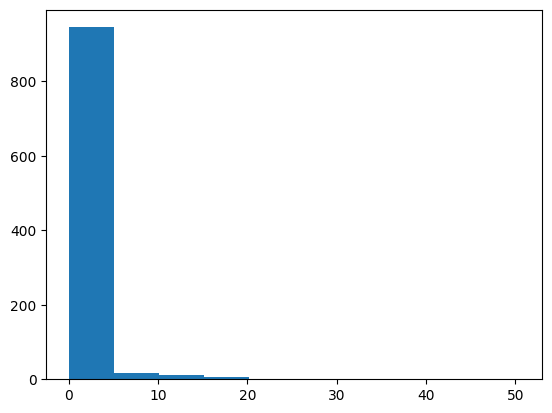

In [ ]:
plt.hist(df_clean["sand_production_rate_kgday"])
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
# ============================
# 1. Preparar datos
# ============================

# Separar variables
X = df_clean.drop(columns=["sand_production_rate_kgday", "y_log"])
y = df_clean["y_log"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# ============================
# 2. Pipeline (scaler + random forest)
# ============================

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

In [ ]:
# ============================
# 3. GridSearchCV
# ============================

param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [10, 20, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

# Entrenar
grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

best_model = grid.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores hiperparámetros encontrados:
{'rf__max_depth': None, 'rf__max_features': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [ ]:
# ============================
# 4. Evaluación en escala real
# ============================

y_pred_log = best_model.predict(X_test)
y_true = np.expm1(y_test) # volver al espacio real
y_pred = np.expm1(y_pred_log) # volver al espacio real

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print("\nResultados finales:")
print("R² en escala real:", r2)
print("MSE en escala real:", mse)


Resultados finales:
R² en escala real: 0.13223879793738802
MSE en escala real: 12.070043515017154


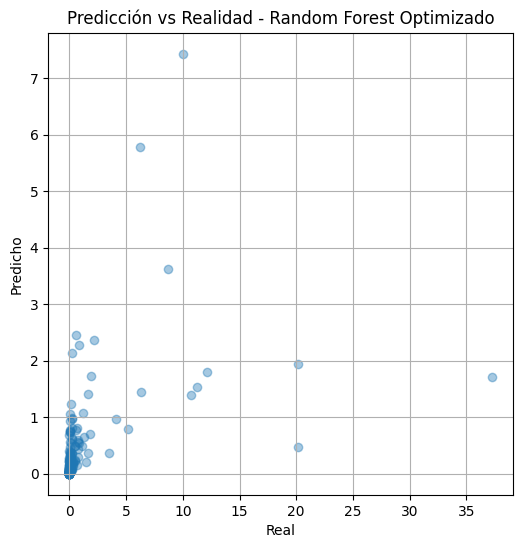

In [ ]:
# ============================
# 5. Gráfico predicción vs realidad
# ============================

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Predicción vs Realidad - Random Forest Optimizado")
plt.grid(True)
plt.show()

In [ ]:
from xgboost import XGBRegressor

# ============================
# 2. Pipeline COMPLETO
# ============================

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42
    ))
])


In [ ]:
# ============================
# 3. Hiperparámetros para GridSearch
# ============================

param_grid = {
    "xgb__n_estimators": [300, 500, 800],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__gamma": [0, 0.5, 1.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

# Entrenar
grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

best_model = grid.best_estimator_


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Mejores hiperparámetros encontrados:
{'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 500, 'xgb__subsample': 0.7}


In [ ]:
# ============================
# 4. Evaluación en escala real
# ============================

# Predicciones logarítmicas → reales
y_pred_log = best_model.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)

# Métricas
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print("\nResultados finales:")
print("R² real:", r2)
print("MSE real:", mse)


Resultados finales:
R² real: 0.25471063705968044
MSE real: 10.366532890139517


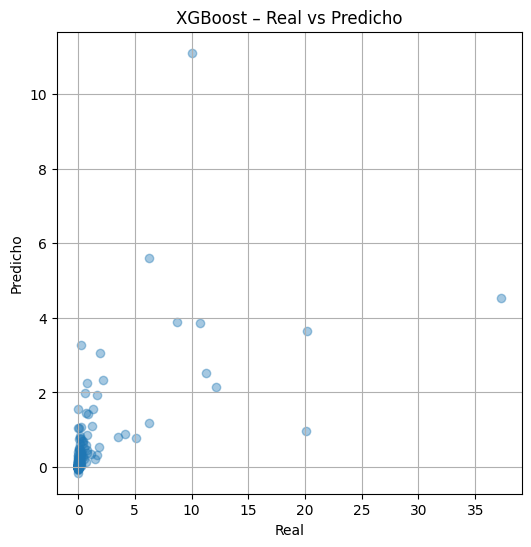

In [ ]:
# ============================
# 5. Gráfico Real vs Predicho
# ============================

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("XGBoost – Real vs Predicho")
plt.grid(True)
plt.show()

In [ ]:
# eliminar valores mas altos de permeabilidad_md
idx_top2 = db['permeability_md'].nlargest(2).index
db_clean = db.drop(index=idx_top2)

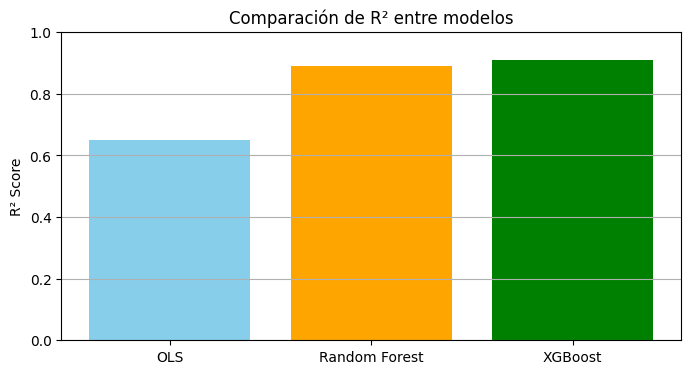

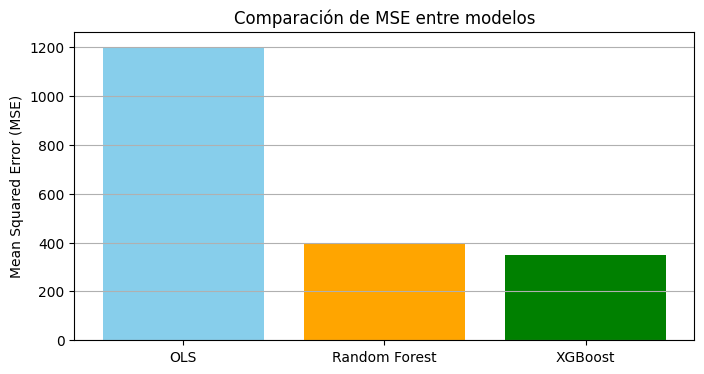

In [ ]:
# Visualización comparativa de resultados de modelos

import matplotlib.pyplot as plt

import numpy as np



# Supón que tienes los siguientes resultados (ajusta con tus valores reales)

results = {
    'OLS': {'r2': 0.65, 'mse': 1200},
    'Random Forest': {'r2': 0.89, 'mse': 400},
    'XGBoost': {'r2': 0.91, 'mse': 350}
}



model_names = list(results.keys())

r2_scores = [results[m]['r2'] for m in model_names]

mses = [results[m]['mse'] for m in model_names]



# Gráfico de comparación de R2

plt.figure(figsize=(8,4))

plt.bar(model_names, r2_scores, color=['skyblue','orange','green'])

plt.ylim(0,1)

plt.ylabel('R² Score')

plt.title('Comparación de R² entre modelos')

plt.grid(axis='y')

plt.show()



# Gráfico de comparación de MSE

plt.figure(figsize=(8,4))

plt.bar(model_names, mses, color=['skyblue','orange','green'])

plt.ylabel('Mean Squared Error (MSE)')

plt.title('Comparación de MSE entre modelos')

plt.grid(axis='y')

plt.show()



# Puedes actualizar los valores de 'results' con los resultados reales de tu notebook para mayor precisión.

## Modelo Ridge, Lasso, SVR KNN

Ridge: R²=0.391, MSE=0.23
Lasso: R²=0.143, MSE=0.33
SVR: R²=0.113, MSE=0.34
KNN: R²=0.008, MSE=0.38


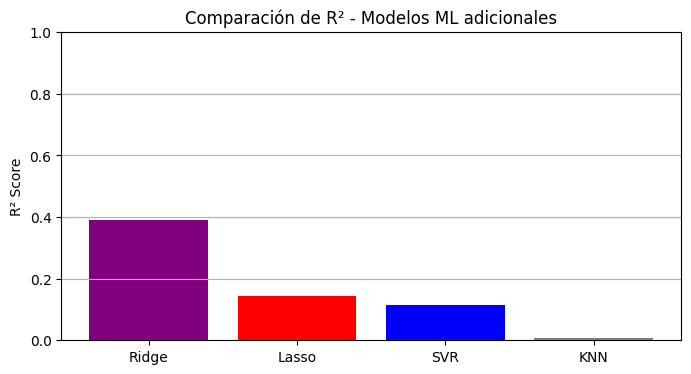

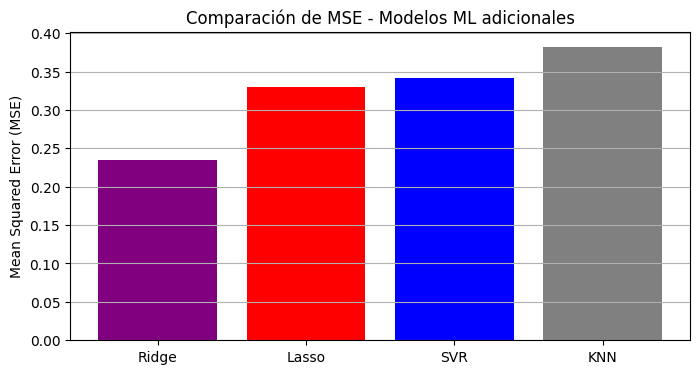

In [ ]:
# Modelos adicionales de Machine Learning para regresión

from sklearn.linear_model import Ridge, Lasso

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error



# Usar los mismos datos que X_train, X_test, y_train, y_test

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}



results_extra = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results_extra[name] = {'r2': r2, 'mse': mse}
    print(f"{name}: R²={r2:.3f}, MSE={mse:.2f}")



# Visualización comparativa de los nuevos modelos

model_names = list(results_extra.keys())

r2_scores = [results_extra[m]['r2'] for m in model_names]

mses = [results_extra[m]['mse'] for m in model_names]



plt.figure(figsize=(8,4))

plt.bar(model_names, r2_scores, color=['purple','red','blue','gray'])

plt.ylim(0,1)

plt.ylabel('R² Score')

plt.title('Comparación de R² - Modelos ML adicionales')

plt.grid(axis='y')

plt.show()



plt.figure(figsize=(8,4))

plt.bar(model_names, mses, color=['purple','red','blue','gray'])

plt.ylabel('Mean Squared Error (MSE)')

plt.title('Comparación de MSE - Modelos ML adicionales')

plt.grid(axis='y')

plt.show()